In [1]:
import pandas
import matplotlib.pyplot as plt
import matplotlib
import pickle
import wntr
import numpy as np
import pandas as pd

import os
import sys
sys.path.append('../WNTR_Model/')

from testWN import testWN as twm

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration, SpectralClustering
from sklearn.decomposition import PCA

matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['svg.fonttype'] = 'none'

In [2]:
%matplotlib notebook

This jupyter notebook is used to evaluated a given clustering. Diagrams are used for the article.

# Get Network Information
We load the `.inp` file within the user defined class `testWN` and populate:
```
testWN.wn = wntr.network.WaterNetworkModel(self.__filePath)
```
The class adds some convenience features that act directly on the network, such as:
```
[tank_names, reservoir_names, junction_names] = ctown.getNodeName()
[pump_names, pipe_names, valve_names] = ctown.getLinkName()
```
These names are used throughout this script.

In [3]:
inp_file = '../WNTR_Model/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
node_names_all = ctown.wn.node_name_list
node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

n_junctions = len(node_names[2])
n_nodes = len(node_names_all)

pump_df = pd.DataFrame(np.ones(len(link_names[0])).reshape(1,-1), columns=link_names[0])
valves_df = pd.DataFrame(np.ones(len(link_names[2])).reshape(1,-1), columns=link_names[2])

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../WNTR_Model/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Get Coordinates of nodes:

In [4]:
nodes = ctown.wn.nodes.todict()

In [5]:
coords_arr = np.array([nodes[key]['coordinates'] for key in nodes.keys()])
coords = pd.DataFrame(coords_arr, index=node_names_all)

# Clustering

## Load Data for plotting:

We processed data from different sources for clustering (as well as learning the surrogate model). Data was created with:
- Random control inputs
- Standard rule based control with random demand patterns
- MPC control with various surrogate models and clustering patterns

Each data source has their individual advantages and disadvantages for clustering.

**Random control inputs:** Result in a very diverse excitement of the system using the control inputs to their full extend. The system is occasionally operating in an unphysical range. 

**Standard rule based control:** The system operates in the desired range. However, controls are not continously and only a limited section of the state-space is explored.

**MPC control:** The system operates in the desired range. Controls are continous. Training data is limited. No training data was available, initially.

Below we only investigate the performance of clustering on the last two datasets.

### with random control input:

In [25]:
file_rc = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/results_sim_59.pkl'

with open(file_rc, 'rb') as f:
    res_rc=pickle.load(f)

### With MPC control:

In [26]:
file_mpc = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/001_economic/027_mod_018_results_sim_time.pkl'

with open(file_mpc, 'rb') as f:
    res_mpc=pickle.load(f)

# Load cluster information:

In [27]:
cluster_labels = pd.read_json('cluster_labels_25cl.json')
pressure_factor = pd.read_json('pressure_factor_25cl.json')
n_clusters = 25

In interesting impression of the data is the demand histogram for each cluster. Plotting this information for individual junctions would be overwhelming. From the histograms we can read, that nodes with similar ranges of demands are likely clustered together. 

<IPython.core.display.Javascript object>


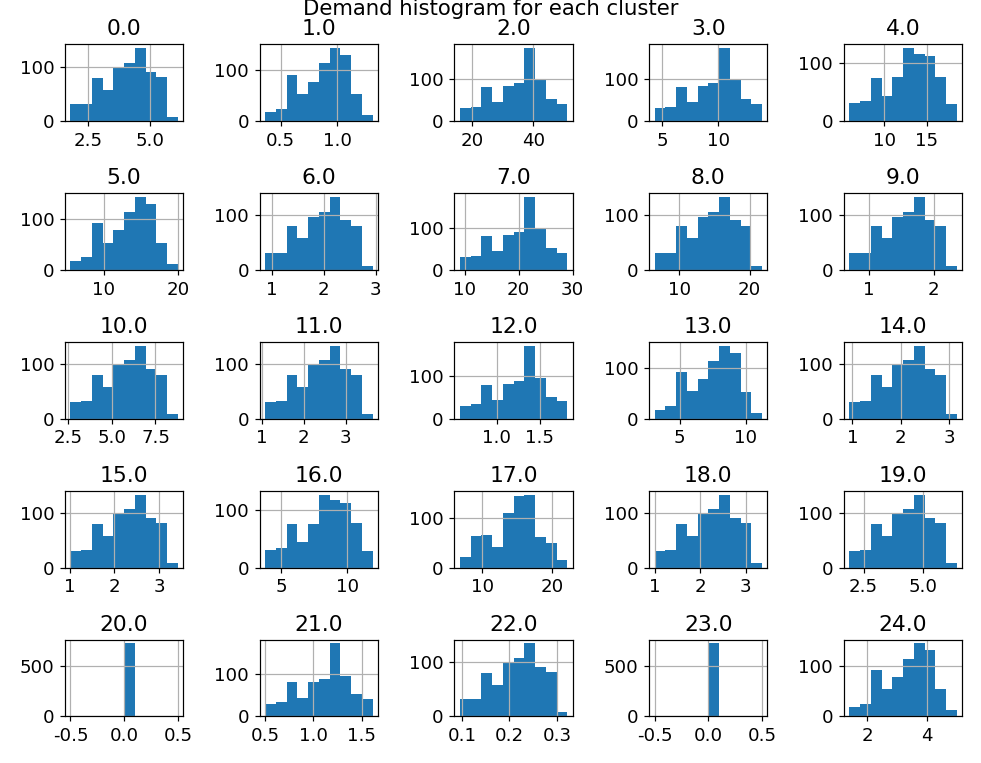

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



In [24]:
fig, ax = plt.subplots(figsize=(9,7))
(res_mpc.node['demand']*1000).groupby(cluster_labels.loc['pressure_cluster'], axis=1).sum().hist(ax=ax)
fig.suptitle('Demand histogram for each cluster', y=1.0, fontsize=14)
fig.tight_layout()

<IPython.core.display.Javascript object>


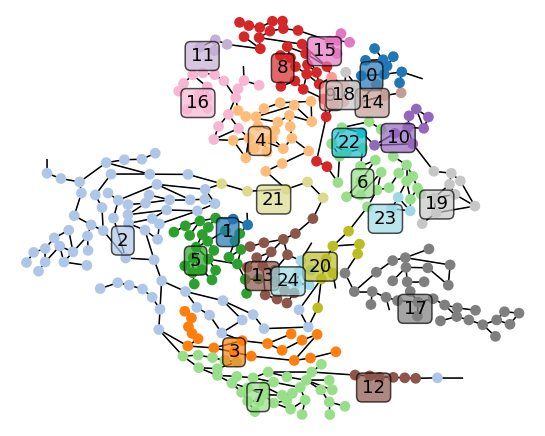

In [28]:
cmap = matplotlib.cm.get_cmap('tab20')

fig_1, ax_1 = plt.subplots(1,1, figsize=(5,4), sharex=True, sharey=True)

press = res_mpc.node['pressure'][node_names[2]]
press_med = press.mean()

# # Highlight pumps
# wntr.graphics.plot_network(ctown.wn, link_attribute=pump_df.loc[0],node_size=1, link_width=6, 
#                            add_colorbar=False, title='Pumps', ax=ax_1[0])
# # Highlight valves
# wntr.graphics.plot_network(ctown.wn, link_attribute=valves_df.loc[0],node_size=1, link_width=6, 
#                            add_colorbar=False, title='Valves', ax=ax_1[0])

lines = wntr.graphics.plot_network(ctown.wn, node_attribute=cluster_labels.loc['pressure_cluster'],
                                   node_size=50, node_labels=False, node_cmap='tab20',
                                   add_colorbar=False, ax=ax_1) 

# wntr.graphics.plot_network(ctown.wn, node_attribute=press_med[node_names[2]],node_size=50, 
#                            node_cmap='CMRmap', title='mean pressure', ax=ax_1[1])  

# mesh = ax_1[1].collections[1]
# mesh.colorbar.set_label('pressure [m]')

if True:
    for i in range(n_clusters):
        cluster_mean = coords.loc[node_names[2]][cluster_labels.loc['pressure_cluster']==i].median()-100
        ax_1.text(*cluster_mean.tolist(), str(i), ha="center", va="center",
                     bbox=dict(boxstyle="round", ec='k', fc=cmap(i/(n_clusters-1)), alpha=0.7))

        fig_1.tight_layout(pad=0.1)



### Evaluation

In [29]:
press_junc_mpc = res_mpc.node['pressure'][node_names[2]]
press_junc_mpc.index = press_junc_mpc.index/3600

pressure_factor = press_junc_mpc.abs().mean()

n_press_junc_mpc = press_junc_mpc / pressure_factor.to_numpy()
# Calculate cluster mean and standard deviation
jun_cl_press_group_mpc = press_junc_mpc.groupby(cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_n_press_group_mpc = n_press_junc_mpc.groupby(cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_n_press_mean_mpc = jun_cl_n_press_group_mpc.mean()
jun_cl_n_press_std_mpc = jun_cl_n_press_group_mpc.std()

To showcase the performance of the clustering algorithm, we plot the normalized pressures for individual clusters as well as the mean value. This can be compared to the physical pressures in the cluster. We also show that the patterns are similar within a cluster but can vary greatly from cluster to cluster. 

<IPython.core.display.Javascript object>


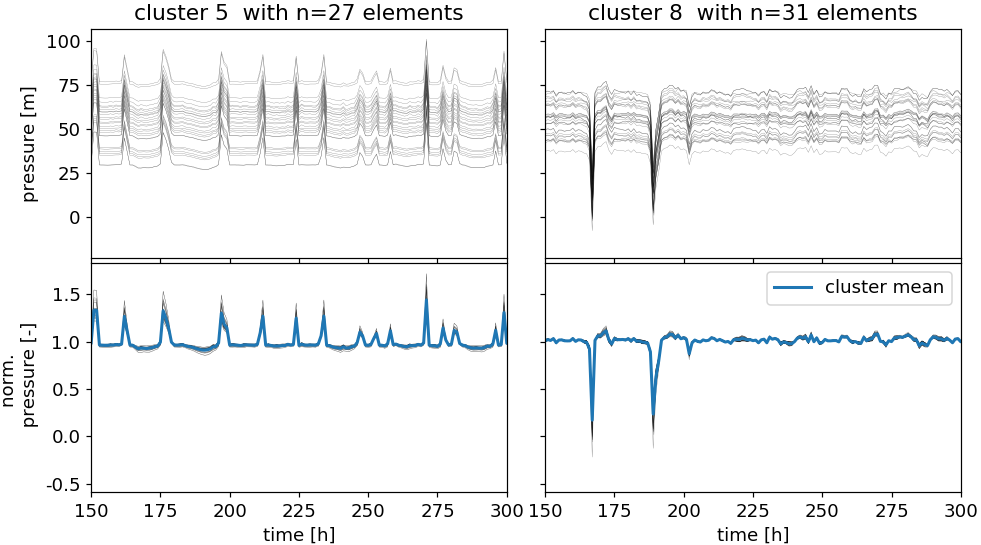

In [30]:
fig, ax = plt.subplots(2,2,figsize=(9,5), sharex=True, sharey='row')


cluster_1=5
cluster_2=8

ax[0,0].plot(jun_cl_press_group_mpc.get_group(cluster_1),color='k', linewidth=0.2, alpha=0.5)

ax[1,0].plot(jun_cl_n_press_group_mpc.get_group(cluster_1),color='k', linewidth=0.2, alpha=0.5)
ax[1,0].plot(jun_cl_n_press_mean_mpc[[cluster_1]], label='cluster mean', linewidth=2)


ax[0,1].plot(jun_cl_press_group_mpc.get_group(cluster_2),color='k', linewidth=0.2, alpha=0.5)
ax[1,1].plot(jun_cl_n_press_group_mpc.get_group(cluster_2),color='k', linewidth=0.2, alpha=0.5)
ax[1,1].plot(jun_cl_n_press_mean_mpc[[cluster_2]], label='cluster mean', linewidth=2)
ax[1,1].legend()

ax[0,0].set_title('cluster {}  with n={} elements'.format(cluster_1, jun_cl_press_group_mpc.get_group(cluster_1).shape[1]))
ax[0,1].set_title('cluster {}  with n={} elements'.format(cluster_2, jun_cl_press_group_mpc.get_group(cluster_2).shape[1]))
ax[1,0].set_xlabel('time [h]')
ax[1,1].set_xlabel('time [h]')
ax[0,0].set_ylabel('pressure [m]')
ax[1,0].set_ylabel('norm. \n pressure [-]')
#ax[1,0].set_ylim(0,1)
#ax[0,0].set_ylim(40,200)
ax[0,0].set_xlim(150,300)

# ax_2.fill_between(jun_cl_press_mean.index,
#                   (jun_cl_press_mean[[cluster_i]]-3*jun_cl_press_std[[cluster_i]]).to_numpy().flatten(),
#                   (jun_cl_press_mean[[cluster_i]]+3*jun_cl_press_std[[cluster_i]]).to_numpy().flatten(), 
#                   alpha=0.5, label='$\pm 3\sigma$')
# ax_2.plot(jun_cl_press_group.get_group(cluster_i),color='k', linewidth=0.2, alpha=0.5)
# ax_2.plot(jun_cl_press_mean[[cluster_i]], label='cluster mean')
# ax_2.plot([0,0],[0,0], color='k', linewidth=0.2, alpha=0.5, label='individual nodes')

# ax_2.legend()
# ax_2.set_title('Normalized pressure for cluster #{}  with n={} elements'.format(cluster_i, jun_cl_press_group.get_group(cluster_i).shape[1]))
# ax_2.set_xlabel('time [s]')
# ax_2.set_ylabel('Pressure')

fig.align_ylabels()
fig.tight_layout(pad=0.2, w_pad=0.2, h_pad=0)